# LLM Similirity Analysis for Medical Questions asked on Reddit 

This analysis consists of understanding differences between a general LLM and medical LLM when it comes to providing medical advice to someone. Here we compare similarity of the LLM response to the physician response to conduct this analysis.

In [21]:
import pandas as pd

df = pd.read_csv("../reddit_data_with_all_similarity.csv")
df = df.rename(columns={
    'Physician/MedLLM Response Similarity': 'med_similarity',
    'Expert/General LLM Response Similarity': 'general_similarity'
})

print(df.head())
print(df.columns)

   Unnamed: 0                                              title  \
0           0                    Leg pain after 4ml IM injection   
1           1                           Exhausted, out of breath   
2           2  Do these symptoms mean I should get a colonosc...   
3           3                 How can I fight my Rosacea problem   
4           4              Thought I was going to die yesterday.   

                                            selftext  \
0  I'm a regular user of anabolic steroids, pepti...   
1  Hi everyone, Today I went to another city with...   
2  My question is about the necessity of a colono...   
3  I am a 21 year old male turning 22 next month....   
4  I (33 M) was standing in the kitchen yesterday...   

                                  physician_comments  \
0  Although I don't know anything about the creat...   
1  Sounds like he has COPD since you say his lung...   
2  Is there any family history of colon cancer or...   
3  Rosacea is a difficult derm

T-statistic: -4.628326018019341, p-value: 1.1307500855765364e-05


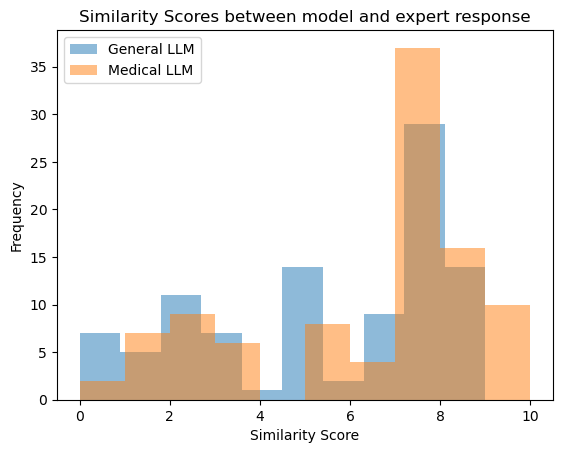

In [22]:
from scipy.stats import ttest_rel

t_stat, p_val = ttest_rel(df['general_similarity'], df['med_similarity'])
print(f"T-statistic: {t_stat}, p-value: {p_val}")

import matplotlib.pyplot as plt

plt.hist(df['general_similarity'],  
         alpha=0.5,
         label='General LLM') 

plt.hist(df['med_similarity'],  
         alpha=0.5,
         label='Medical LLM') 
  
plt.legend(loc='upper left') 
plt.title('Similarity Scores between model and expert response') 
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

#### Feature Engineering
Here we are deriving some important imformation from the reddit prompts that we will use in analysis

In [30]:
import re

df['word_count'] = df['combined_text'].apply(lambda x: len(str(x).split()))
df['has_image_link'] = df['combined_text'].str.contains(r'(https?://\S+\.(jpg|jpeg|png|gif))', flags=re.IGNORECASE, na=False)

personal_info_patterns = [
    r'\bage\b', r'\b[0-9]{1,3} (years? old|yo)\b',  # e.g., "25 years old"
    r'\bheight\b', r'\bweight\b', r'\blbs\b', r'\bkg\b',  # height/weight units
    r'\bpregnan', r'\bgender\b', r'\bfemale\b', r'\bmale\b',  # gender/pregnancy
    r'\bsex\b', r'\btrans\b', r'\bnon[-\s]?binary\b',
    r'\bsmok(er|ing)\b', r'\balcohol\b', r'\bdiabetic\b', r'\bobese\b',
    r'\bBMI\b', r'\bbody mass\b', r'\bblood pressure\b'
]

pattern_combined = '|'.join(personal_info_patterns)
df['mentions_personal_info'] = df['combined_text'].str.contains(pattern_combined, flags=re.IGNORECASE, na=False)

def count_personal_info(text):
    text = str(text).lower()
    return sum(bool(re.search(p, text)) for p in personal_info_patterns)

df['num_personal_details'] = df['combined_text'].apply(count_personal_info)



def categorize_issue(text):
    text = str(text).lower()
    if any(word in text for word in ['rash', 'acne', 'itch']):
        return 'dermatology'
    elif any(word in text for word in ['pain', 'injury', 'fracture']):
        return 'orthopedic'
    elif any(word in text for word in ['heart', 'chest pain']):
        return 'cardiology'
    else:
        return 'other'

df['issue_group'] = df['combined_text'].apply(categorize_issue)


/var/folders/dc/c48y5rmx59z770gp8x9c71wr0000gn/T/ipykernel_32557/4128847179.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_image_link'] = df['combined_text'].str.contains(r'(https?://\S+\.(jpg|jpeg|png|gif))', flags=re.IGNORECASE, na=False)
/var/folders/dc/c48y5rmx59z770gp8x9c71wr0000gn/T/ipykernel_32557/4128847179.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['mentions_personal_info'] = df['combined_text'].str.contains(pattern_combined, flags=re.IGNORECASE, na=False)


### Explore Factors that Might Affect LLM Similarity
here we are using a regression to understand how these features may affect similarity scores

In [31]:
import statsmodels.formula.api as smf

df['similarity_diff'] = df['med_similarity'] - df['general_similarity']
model = smf.ols('similarity_diff ~ word_count + num_personal_details + mentions_personal_info + has_image_link + C(issue_group)', data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        similarity_diff   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     3.482
Date:                Wed, 07 May 2025   Prob (F-statistic):            0.00237
Time:                        15:34:59   Log-Likelihood:                -185.87
No. Observations:                  99   AIC:                             387.7
Df Residuals:                      91   BIC:                             408.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

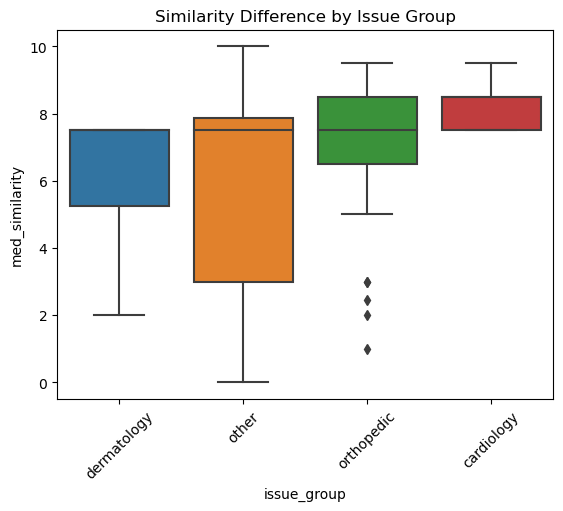

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='issue_group', y='med_similarity', data=df)
plt.xticks(rotation=45)
plt.title("Similarity Difference by Issue Group")
plt.show()


In [28]:
model = smf.ols('med_similarity ~ word_count + mentions_personal_info + has_image_link + C(issue_group)', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         med_similarity   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9822
Date:                Wed, 07 May 2025   Prob (F-statistic):              0.442
Time:                        15:34:01   Log-Likelihood:                -236.47
No. Observations:                  99   AIC:                             486.9
Df Residuals:                      92   BIC:                             505.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [26]:
model = smf.ols('general_similarity ~ word_count + mentions_personal_info + has_image_link + C(issue_group)', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     general_similarity   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     2.280
Date:                Wed, 07 May 2025   Prob (F-statistic):             0.0426
Time:                        15:33:47   Log-Likelihood:                -235.01
No. Observations:                  99   AIC:                             484.0
Df Residuals:                      92   BIC:                             502.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   